## Ising Spin Configuration Classification

The Ising model is given by the (classical) Hamiltonian:

\begin{align}
H(\boldsymbol{\sigma}) = -\sum_{<ij>} \sigma_{i}\sigma_{j},
\end{align}
where the spins $\sigma_{i} \in \lbrace -1, 1 \rbrace$ are binary variables living on the vertices of a square lattice and the sum is taken over nearest neighbours $<ij>$.
  
At a given temperature $\beta = 1/T$, the probability of a configuration $\sigma$ is given by the Boltzmann distribution
  
\begin{align}
  P(\boldsymbol{\sigma}) = \frac{e^{-\beta H(\boldsymbol{\sigma})}}{Z},
 \end{align}
  
  where $Z$ is the partition function. This model exhibits a phase transition from the ferromagnetic phase at low tempertures to a paramagnetic phase at high temperatures. The transition temperature is $T_c \approx 2.2692$.
  
  **Task**

1.   Classify the ferromagnetic versus the paramagnetic phase of the Ising model
2.   Find the transition temperature
  
**Dataset**: Monte Carlo generated configurations on a 30x30 square lattice. The configuration are labelled by temperature.

### 1. Import data and analyze the data shape

In [1]:
# Helper Libraries
import numpy as np
import scipy as sp
from scipy.special import softmax

# Machine learning related libraries:
import torch
import torch.nn as nn            # base class used to develop all neural network models
import torch.nn.functional as F  # module of relu activation functions
import torch.optim as optim      # module of Adam optimizer

# from itertools import chain      # append two range() functions
from torch.utils.data import DataLoader # easy and organized data loading to the ML model
from torch.utils.data import Dataset #for nice loadable dataset creation

# setup plotting
import matplotlib.pyplot as plt
plt.style.use('./SciencePlots-APS.mplstyle')

In [2]:
####### Detect if running on the clusters  #######
# use CUDA:
torch.cuda.is_available()
print("Is cuda available?", torch.cuda.is_available())

# set a flag
device = torch.device("cuda:0")

if torch.cuda.is_available():
    device = torch.device("cuda:0")  # you can continue going on here, like cuda:1 cuda:2....etc.
    print("Running on the GPU")
else:
    device = torch.device("cpu")
    print("Running on the CPU")

Is cuda available? False
Running on the CPU


In [3]:
# Create folder to save the model 
directory = "./ising-data/"

# linear dimension of the lattice
N = 30 
ising_training_configs = np.load("{1}/ising_training_configs_{0}x{0}.npy".format(N, directory))
ising_training_labels = np.load("{1}/ising_training_labels_{0}x{0}.npy".format(N,directory))
ising_test_configs = np.load("{1}/ising_test_configs_{0}x{0}.npy".format(N,directory))
ising_test_labels = np.load("{1}/ising_test_labels_{0}x{0}.npy".format(N,directory))

print('train_images.shape =', ising_training_configs.shape)
print('train_labels.shape =', ising_training_labels.shape)
print('test_images.shape =', ising_test_configs.shape)
print('test_labels.shape =', ising_test_labels.shape)

train_images.shape = (1000, 30, 30)
train_labels.shape = (1000,)
test_images.shape = (1000, 30, 30)
test_labels.shape = (1000,)


We see that we have a training set of size 1000 and a test set of size 1000.

Each image is a 30x30 array which takes values in {-1, 1}. The labels of these images are the temperatures and they are in [1, 3.5]. Let us plot some data to understand it further.

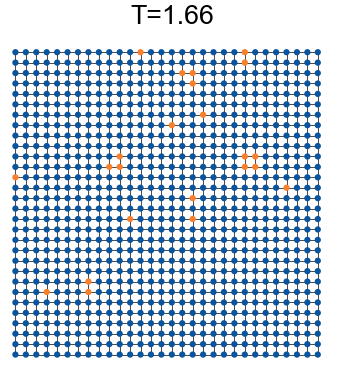

In [4]:
def plot_Ising_configuration(spins, ax=None):
    '''
    this is just a helper function to plot the configuration of spins  given by 'spins'
    '''
    if ax==None:
        print("problem")
        ax = plt.gca()
    N = np.shape(spins)[1]
    for i in range(N):
        ax.plot([i, i], [0,N-1], 'k', zorder=0, linewidth=0.5)
        ax.plot([0,N-1], [i,i], 'k', zorder=0, linewidth=0.5)

    cmap=plt.cm.Blues
    cmap2=plt.cm.Oranges
    cmap(1)
    colors = [cmap2(140), cmap(220)] # note: orange is down, blue is up!
    colors = [cmap(220), cmap2(140)] # note: blue is down, orange is up!
    for i in range(N):
        for j in range(N):
            ax.add_patch(plt.Circle((i,j), radius=0.3, fc=colors[int((spins[i,j]+1)/2.)], zorder=2))

    ax.axes.set_axis_off()
    ax.set_ylim(-1,N+1)
    ax.set_xlim(-1,N+1)
    ax.set_aspect('equal')

fig = plt.figure()
fig.set_size_inches(3.40457, 9)
fig.subplots_adjust(wspace=0.01,hspace=0.08, left=0.01, right=0.99, bottom=0.05, top=0.99)
ax1 = fig.add_subplot(1,1,1)

plot_Ising_configuration(ising_training_configs[300], ax1)
ax1.set_title("T={:1.2f}".format(ising_training_labels[250]))
ax1.title.set_position((0.5,-0.1))

### 2. Prepare data

At the moment, our configurations are labelled by their temperature. Since we want to learn to classify the two phases, we need to label our data by <b>Ordered</b> (label=0) vs <b>Disordered</b> (label=1).

Let us assume that we know $1.5=T_{low}<T_{c}< T_{high} = 2.5$. Then we exclude all the data between $T_{low}$ and $T_{high}$. We label all configurations below $T_{low}$ with '0' and all those above $T_{high}$ with '1'.

In [5]:
T_low = 1.5   # define the low temperature
T_high = 2.5  # define the hight temperature

NUM_TRAINING = len(ising_training_labels)    # number of training samples
NUM_TEST = len(ising_test_labels)    # number of test samples

REBUILD_DATA = True # set to true to one once, then back to false unless you want to change something in your training data.

![Ising_learning](../imag/supervised_ising.png)

In [6]:
# Combine the configuration with their labels:

class datafunc_IsingConfig():
    # Class that handles the raw data

    def __init__(self, NUM_TRAINING, NUM_TEST):
        #we input the number of training and test samples when initializing the class
        self.NUM_TRAINING = NUM_TRAINING
        self.NUM_TEST = NUM_TEST

        # creat the list that combine the label and ising configurations
        # empty list, will populate data and labels later on
        self.training_data = []
        self.test_data = []

    def make_training_data(self):
        for i in range(self.NUM_TRAINING): # for each sample
            label = ising_training_labels[i]
            if label < T_low:
                self.training_data.append([ising_training_configs[i].flatten(),0]) # combine the config and the phase label
            if label > T_high:
                self.training_data.append([ising_training_configs[i].flatten(),1])

        np.random.shuffle(self.training_data)
        np.save("{}/training_data_ising.npy".format(directory), np.array(self.training_data,dtype=object))

    def make_test_data(self):
        for i in range(self.NUM_TEST): # for each sample
            label = ising_test_labels[i]
            if label < T_low:
                self.test_data.append([ising_test_configs[i].flatten(),0]) # combine the config and the phase label
            if label > T_high:
                self.test_data.append([ising_test_configs[i].flatten(),1])

        np.random.shuffle(self.test_data)
        np.save("{}/test_data_ising.npy".format(directory), np.array(self.test_data,dtype=object))

if REBUILD_DATA:
    dataclass_IsingConfig =  datafunc_IsingConfig(NUM_TRAINING, NUM_TEST)
    dataclass_IsingConfig.make_training_data()
    dataclass_IsingConfig.make_test_data()

In [7]:
# Now we have nice loadable datafile with labels

# load the training and test data:
training_data_ising = np.load("{}/training_data_ising.npy".format(directory), allow_pickle=True)
test_data_ising = np.load("{}/test_data_ising.npy".format(directory), allow_pickle=True)

# make them torch tensor
train_X_ising = torch.Tensor(np.array([i[0] for i in training_data_ising]))
train_y_ising = torch.Tensor(np.array([i[1] for i in training_data_ising]))

test_X_ising = torch.Tensor(np.array([i[0] for i in test_data_ising]))
test_y_ising = torch.Tensor(np.array([i[1] for i in test_data_ising]))

print("len(train_X_ising), len(test_X_ising) is ", len(train_X_ising), len(test_X_ising))

len(train_X_ising), len(test_X_ising) is  600 600


In [8]:
len(train_X_ising[1])

900

final step: we take our training and labeled data and create a custom dataset class that we will then pass on to the dataloader

In [9]:
class CustomDataset(Dataset):
    def __init__(self, data, labels):
        # we pass data and labels when we initialize the class
        self.data = data
        self.labels = labels

    def __len__(self):
        # function that outputs length of dataset
        return len(self.data)

    def __getitem__(self, idx):
        # function that outputs data item with index idx
        # return data, label
        data_idx = self.data[idx]
        label = self.labels[idx].type(torch.LongTensor) # label must be output as datatype=Long (also known as int64)
        # note: if you run into error when loading the class, try:
        # label = self.labels[idx][0].type(torch.LongTensor)   #### works for PyTorch 0.4.1.
        # label = self.labels[idx].type(torch.LongTensor)      #### works for PyTorch>=0.5.
        return data_idx, label

In [10]:
# training dataset
train_dataset_class = CustomDataset(train_X_ising, train_y_ising)
# test dataset
test_dataset_class = CustomDataset(test_X_ising, test_y_ising)

In [11]:
# we pass the dataset as an argument to DataLoader -> automatic batching, sampling, shuffling etc.
batch_size = 16

# create data loaders
train_dataloader = DataLoader(train_dataset_class, batch_size = batch_size)
test_dataloader = DataLoader(test_dataset_class, batch_size = batch_size)

In [12]:
# check that the dataloader works correctly and give the right shape and type
for X, y in train_dataloader:
    print(f"Shape of X: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    print(y)
    break

Shape of X: torch.Size([16, 900])
Shape of y: torch.Size([16]) torch.int64
tensor([0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0])


### 3. Setup the model

Specifications of our model:

*  Our model takes in a 30 by 30 array
*  And outputs a 2-dimensional vector

The 2-dimensional vector gives the models prediction for whether the system is ferromagnetic (i.e., T < Tc) or paramagnetic (T>Tc).

The model's prediction is given by the index with the largest value, i.e. argmax(output)

The basic building block is the layer. A layer takes some input tensor and applies some transformation and returns an output tensor.

First let us explore the sequential model.

![supervised_learning_chart](../imag/supervised_learning_chart.png)

In [13]:
# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")


# Define model (FINALLY!)
# One example of how to do that: input size is 30 x 30 = 900, followed by
# one fully connected layer with ReLU activation function and binary (1/0) output

# we define a class for the neural network
# torch requires this class to have a method .forward(x)
# it is convention to define the network during initialization of the class

class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork,self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(900,32),
            nn.ReLU(),
            nn.Linear(32,2),
        )

    def forward(self,x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

# here we initialize an instance of the class
model = NeuralNetwork().to(device)
# print the status of the model
# the print command is inherited from nn.Module in the definition of the network
print(model)

Using cpu device
NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=900, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=2, bias=True)
  )
)


In [14]:
# print the number of trainableparameters:
pytorch_total_params = sum(p.numel() for p in model.parameters())
print(f"Trainable params: {pytorch_total_params}")

Trainable params: 28898


### 4. Compile the model

Now that the model is defined, we need to train our model. But before doing so, there are a few details we need to specify.


1.   Loss function: we need to choose what function we want our model to minimise e.g. mean square error or cross entropy or ...
2.   Optimisation method: How we want to update the weights e.g. stochastic gradient descent or ADAM or ...
3.   Metrics: some quantity we want to keep track off while we are training, e.g. value of the loss function or the accuracy of the model...

In [15]:
# optimizing the model parameters
# to train the model we need a LOSS FUNCTION and an OPTIMIZER

loss_fn = nn.CrossEntropyLoss() # we use Cross Entropy as loss
optimizer = torch.optim.Adam(model.parameters(),lr=1e-2) # The optimizer is Adam

### 5. Train the model

Finally we are ready to train our model. Here we basically just need to feed the data set to our model, and the model would minimise the loss function we chose and update the model parameters according to the optimisation method we specified.

The last thing we need to choose is the number of epochs and the batch_size.


*   batch_size: this is the number of images we feed to our model in 1 iteration
*   epochs: the number of times we run through our data set.

Let's suppose batch size = 100. Then the training proceeds as follows:

1.   Divide our dataset in batches of 100.
2.   Take a batch of 100 samples and feed it to the model. This gives 100 output vectors from which we compute the loss function and its gradient w.r.t. to model parameters.
3. Use the gradients to update the model parameters according to the optimiser we chose
4. Repeat steps 2 and 3 until we have cycled through to the end of the dataset. This will be the end of one epoch.

Number of iterations in one epoch = size of data set / batch_size


A few comments:

* The smaller the batch size, the faster the model trains.
* The smaller the batch size, the more noisy the training will be.
* Some amount of noise is useful to prevent us from getting stucked in local minima.

In [16]:
# define the train and test loss accumulation
train_loss_dnn = []
train_acc_dnn = []
test_loss_dnn = []
test_acc_dnn = []

# define training function: make predicition on data set batch,
# backpropagate the error and adjust model parameters

def train(dataloader, model, loss_fn, optimizer, train_loss, train_acc):
    num_batches = len(dataloader)
    size = len(dataloader.dataset)
    model.train()
    running_loss, correct = 0, 0
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        #compute prediction error
        pred = model(X)
        loss = loss_fn(pred,y)

        #Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # collect the accuracy:
        running_loss += loss.item()
        correct += (pred.argmax(1)==y).type(torch.float).sum().item()

        if batch % 25==0:
            loss,current = loss.item(), batch*len(X)
            print(f"loss: {loss:>7f} [{current:>5d}/{size:>5d}]")
    running_loss /= num_batches
    correct /= size

    train_acc.append(correct)
    train_loss.append(running_loss)

#check performance against the test data set
def test(dataloader,model,loss_fn,test_loss, test_acc):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    running_loss, correct = 0, 0
    with torch.no_grad():
        for X,y in dataloader:
            X,y = X.to(device), y.to(device)
            pred = model(X)
            running_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1)==y).type(torch.float).sum().item()
    running_loss /= num_batches
    correct /= size

    test_acc.append(correct)
    test_loss.append(running_loss)
    print(f"Test Error: \n Accuracy {(100*correct):>0.1f}%, Avg loss:{running_loss:>8f}\n")

epochs = 10

for t in range(epochs):
    print(f"Epoch {t+1}\n -------------------")
    train(train_dataloader,model,loss_fn,optimizer, train_loss_dnn, train_acc_dnn)
    test(test_dataloader,model,loss_fn, test_loss_dnn, test_acc_dnn)
print("Done!")

Epoch 1
 -------------------
loss: 0.656802 [    0/  600]
loss: 0.289849 [  400/  600]
Test Error: 
 Accuracy 83.2%, Avg loss:0.238394

Epoch 2
 -------------------
loss: 0.126847 [    0/  600]
loss: 0.001023 [  400/  600]
Test Error: 
 Accuracy 95.2%, Avg loss:0.128592

Epoch 3
 -------------------
loss: 0.000161 [    0/  600]
loss: 0.000560 [  400/  600]
Test Error: 
 Accuracy 96.2%, Avg loss:0.098964

Epoch 4
 -------------------
loss: 0.000120 [    0/  600]
loss: 0.000420 [  400/  600]
Test Error: 
 Accuracy 96.8%, Avg loss:0.088363

Epoch 5
 -------------------
loss: 0.000097 [    0/  600]
loss: 0.000329 [  400/  600]
Test Error: 
 Accuracy 97.0%, Avg loss:0.081778

Epoch 6
 -------------------
loss: 0.000080 [    0/  600]
loss: 0.000263 [  400/  600]
Test Error: 
 Accuracy 97.0%, Avg loss:0.077020

Epoch 7
 -------------------
loss: 0.000065 [    0/  600]
loss: 0.000215 [  400/  600]
Test Error: 
 Accuracy 97.2%, Avg loss:0.073286

Epoch 8
 -------------------
loss: 0.000054 [   

In [17]:
def create_acc_loss_graph(train_acc,train_loss, test_acc, test_loss):
    '''
    '''
    fig, axes = plt.subplots(ncols=2, nrows=1, dpi=300)
    fig.set_size_inches(9, 3)
    ax1, ax2 = axes[0], axes[1]

    ax1.plot(train_acc,'-o',label="train", markersize=4)
    ax1.plot(test_acc,'--+',label="test", markersize=4)
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend(loc=3)

    ax2.plot(train_loss,'-o',label="train", markersize=4)
    ax2.plot(test_loss,'--+',label=" test", markersize=4)
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend(loc=1)

    #plot parameters
    ax1.set_ylim(0, np.max([np.max(train_acc),np.max(test_acc)])+0.1)
    ax2.set_ylim(-0.1, np.max([np.max(train_loss),np.max(test_loss)])+0.1)
    ax1.grid(True, which='both',linewidth=0.1)
    ax2.grid(True, which='both',linewidth=0.1)
    plt.tight_layout()
    plt.show()

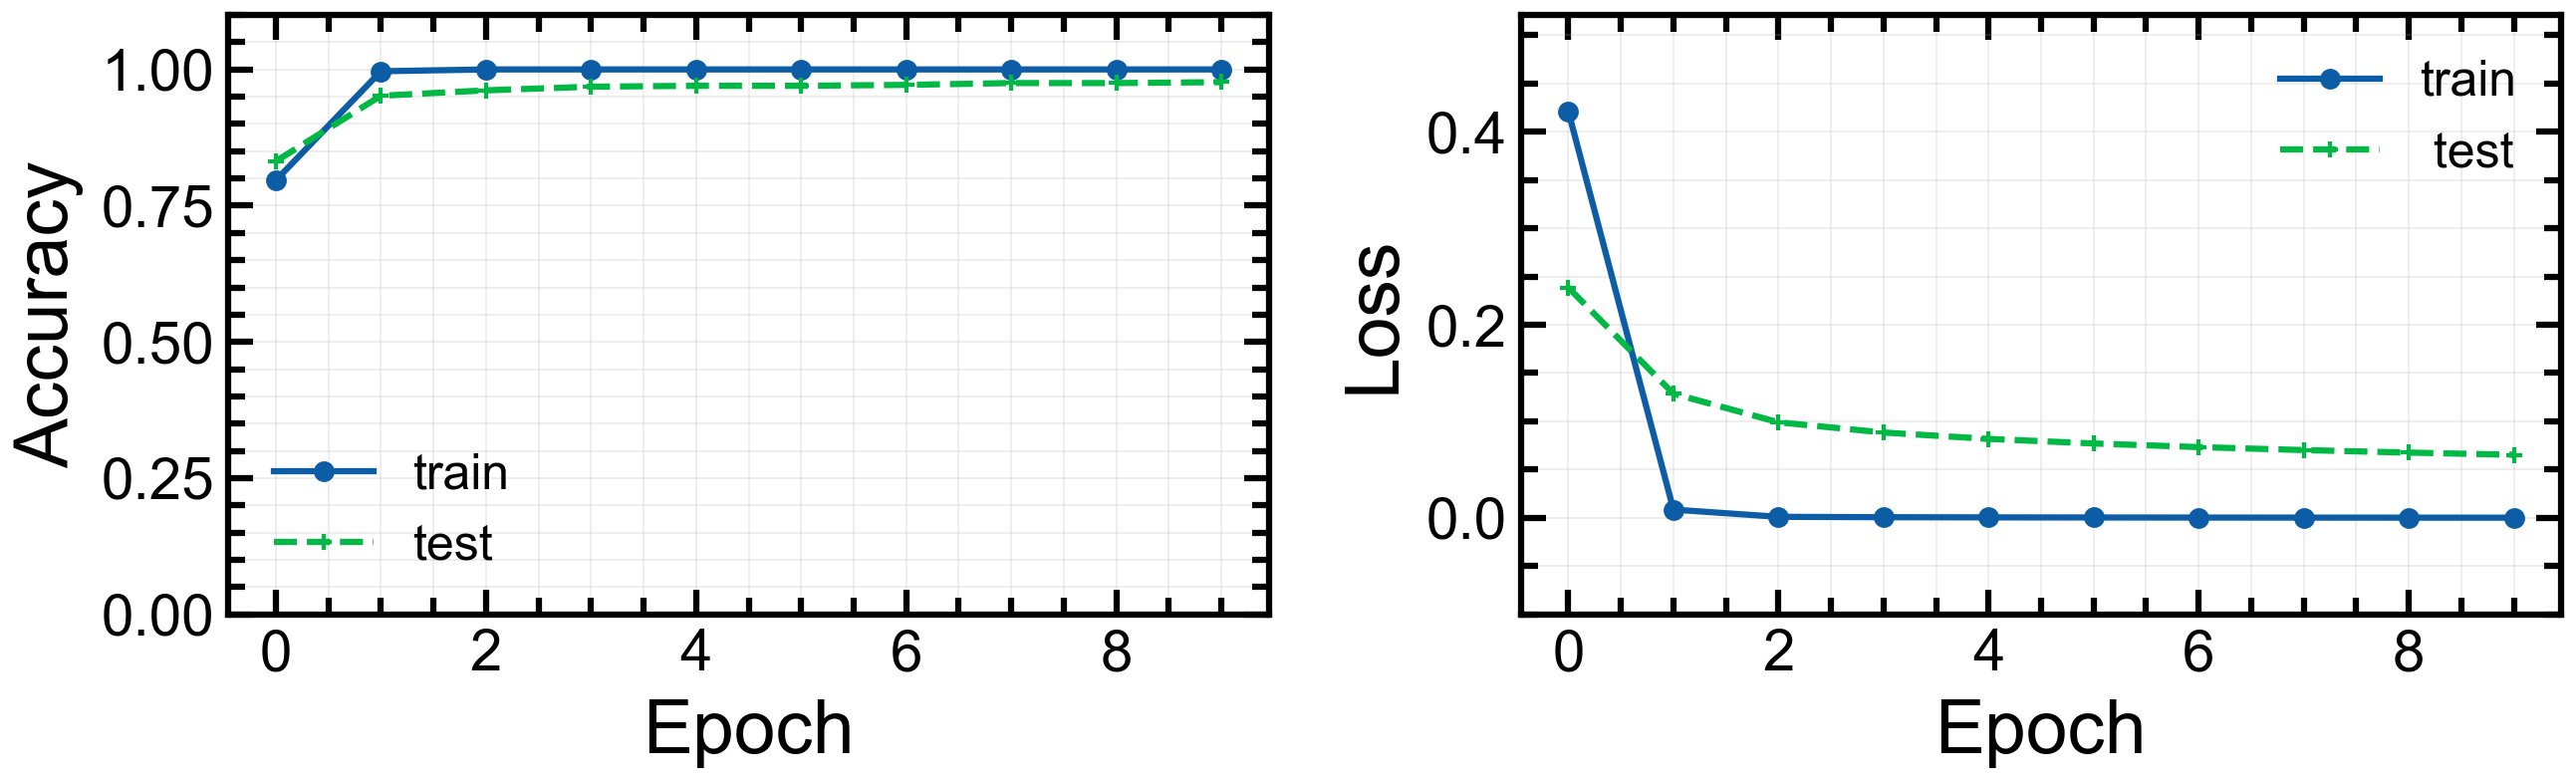

In [18]:
create_acc_loss_graph(train_acc_dnn,train_loss_dnn, test_acc_dnn, test_loss_dnn)

### 6. Interpretation and analysis

Now that our model is trained, we can test our model on the configurations we have not yet seen (`ising_test_configs`).
- How to get the critical temperature from our NN model?

In [19]:
# print the shape of the model prediction and the shape of the labels
for X, y in test_dataloader:
    predict = model(X.to(device))
    print(predict)
    print(y)
    break

tensor([[ 1.7322, -8.1885],
        [-2.0777,  1.3825],
        [-2.2709,  0.9860],
        [-2.8796,  2.2949],
        [ 1.7920, -8.2914],
        [ 1.3917, -8.9365],
        [-8.6444,  4.5132],
        [-0.5063, -2.3244],
        [-5.5080,  3.1220],
        [-5.4046,  2.1617],
        [-2.5441,  1.7737],
        [-2.7929,  3.0510],
        [-2.2719, -0.2802],
        [-2.5333, -0.8200],
        [-4.6370,  2.4996],
        [-2.7743,  1.9368]], grad_fn=<AddmmBackward0>)
tensor([0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])


In [20]:
# make a prediction on the test data set
prediction = model(torch.Tensor(ising_test_configs).to(device))
print(len(prediction))

1000


In [21]:
Temps = list(np.sort(list(set(ising_test_labels))))
NT = len(Temps)
phase1 = np.zeros(NT)
phase2 = np.zeros(NT)
points = np.zeros(NT)
m = np.zeros(NT)
lastT = 0.

# loop over the test data set
for i, T in enumerate(ising_test_labels):
    j = Temps.index(T)
    phase1[j]+=softmax(prediction[i].cpu().detach().numpy())[0]
    phase2[j]+=softmax(prediction[i].cpu().detach().numpy())[1]
    # put soft max  here at prediction
    m[j] += abs(np.mean(ising_test_configs[i]))
    points[j]+=1.

# normalize the data
for j in range(NT):
    phase1[j] /=  points[j]
    phase2[j] /=  points[j]
    m[j] /= points[j]

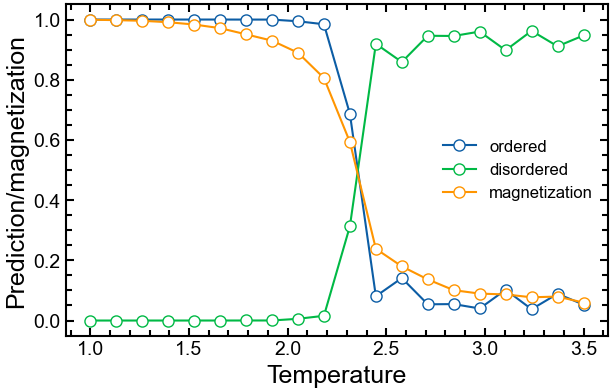

In [24]:
fig = plt.figure()

plt.plot(Temps, phase1, '-o', ms=8, mfc='w', label='ordered')
plt.plot(Temps, phase2, '-o', ms=8, mfc='w', label='disordered')
plt.plot(Temps, m, '-o', ms=8, mfc='w', label='magnetization')

plt.xlabel('Temperature')
plt.ylabel('Prediction/magnetization')
plt.legend()
plt.show()

In [25]:
index = (np.abs(phase1 - 0.5)).argmin()
tc = Temps[index]
print("Estimated Transition Temp =", tc)

Estimated Transition Temp = 2.3157894736842106


   The exact transition temperature in the thermodynamic limit is  2.2692 , so our result is not so bad considering finite size effects. If we look again at the above plot, we can see that the curves coincide relatively nicely with the average magnetization, this suggest that the network is indeed learning the magnetization, i.e. it is computing the magnetization and using it to make its prediction.